In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Configuration
pd.options.display.max_columns=100
%matplotlib inline 

In [ ]:
#Load and format data
data = pd.read_csv('../inputs/loan.csv', low_memory=False,
                   dtype={'term':np.str}, parse_dates=['last_pymnt_d','issue_d', 'term']
                  )

In [ ]:
data['issue_y']=data['issue_d'].apply(lambda x: x.year)
data['last_pymnt_y']=data['last_pymnt_d'].apply(lambda x: x.year)

In [ ]:
data['last_pymnt_d'].max()

In [ ]:
data.drop(['url', 'desc', 'annual_inc_joint', 'dti_joint',
       'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m',
       'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util',
       'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
       'verification_status','revol_bal', 'revol_util', 'initial_list_status',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type' ], axis=1, inplace=True);
data.dtypes
data.columns
data=data.dropna(axis=1, how='all')
#data=data.dropna(axis=0, how='any')

In [ ]:
data['term'] = data['term'].apply(lambda x: x[0:3])
data['term'] = pd.to_numeric(data['term'])
data['pymnt_duration']=((data['effective_term']/ np.timedelta64(1, 'M')).round())
data['pymnt_delay']=data['pymnt_duration']-data['term']

In [ ]:
plt.figure()
plt1 = sns.countplot(x="issue_y", data=data)
plt1.set_xticklabels(labels=plt1.get_xticklabels(), rotation=45)
plt1.show()

In [ ]:
data.shape[0]
# Select all loans that could potentienly go trough term + 6 month delay
valid_data = data[ ( (data['issue_d'] < np.datetime64('2012-06-01')) & (data['term']==36) ) 
                | ( (data['issue_d'] < np.datetime64('2010-06-01')) & (data['term']==60) ) ]
valid_data = valid_data[valid_data['term']<37]

In [ ]:
valid_data.shape
valid_data

In [ ]:
sns.pairplot(data, size = 2.5, plot_kws={'alpha':0.005}, dropna=True)

In [ ]:
plt.show()

In [ ]:
plt.figure()
plt1 = sns.countplot(x="issue_y", data=data)
plt1.set_xticklabels(labels=plt1.get_xticklabels(), rotation=45)
plt.show()

In [ ]:
fully_paid = data[data['loan_status'].isin(['Fully Paid'])]
fully_paid.shape
fully_paid[fully_paid['pymnt_delay']>0].shape

#plt.figure()
#valid_data.boxplot(column='pymnt_delay', by='grade')
#plt.show()
#data[data['pymnt_delay']>0].head(2)
#valida_data[valida_data['pymnt_delay']>0].describe

In [ ]:
valid_data['gain']=valid_data['total_pymnt']-valid_data['loan_amnt']
valid_data['relative_gain']=valid_data['gain']/valid_data['loan_amnt']*100

In [ ]:
sns.jointplot(x='pymnt_delay', y='relative_gain', data=valid_data, joint_kws={'alpha':0.08})
plt.show()

sns.jointplot(x='pymnt_delay', y='relative_gain', data=valid_data, joint_kws={'alpha':0.08}, xlim={0,5}, ylim={0,40})
plt.show()

plt.figure()
data2 = valid_data[valid_data['pymnt_delay']>=0]
data2.boxplot(column='relative_gain', by='pymnt_delay')
data2.boxplot(column='relative_gain', by='pymnt_delay')
plt.show()

In [ ]:
data2.size
data2[data2['pymnt_delay']==4].size

In [ ]:
#Quel est le retour sur investissement de chaque prêt? Total/Annuel/Mensuel
plt.figure()
valid_data.boxplot(column='relative_gain', by='grade')
plt.show()

In [ ]:
plt.figure()
plt1 = sns.countplot(x="loan_status", data=valid_data)
plt1.set_xticklabels(labels=plt1.get_xticklabels(), rotation=45)
plt.show()

In [ ]:
T=valid_data['pymnt_duration']
G=valid_data['relative_gain']
I=valid_data['loan_amnt']
NAR = (np.power(np.abs((G/100+1)),12/T)-1) * ((G>0)-0.5)*2*100
NAR=NAR.replace([np.inf, -np.inf], 0)
valid_data['NAR']=NAR
valid_data['NAR'].mean()

In [ ]:
valid_data['int_rate'].mean()

In [ ]:
plt.figure()
valid_data.boxplot(column='int_rate', by='grade')
plt.show()

In [ ]:
plt.figure()
valid_data.boxplot(column='NAR', by='grade', showfliers=False)
plt.show()

In [ ]:
valid_data

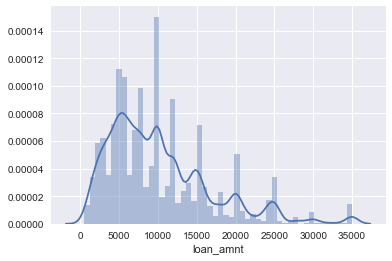

In [238]:
sns.distplot(valid_data['loan_amnt'])
sns.distplot(valid_data['loan_amnt'])
sns.distplot(valid_data['loan_amnt'])
sns.distplot(valid_data['loan_amnt'])
sns.distplot(valid_data['loan_amnt'])
sns.distplot(valid_data['loan_amnt'])
sns.distplot(valid_data['loan_amnt'])

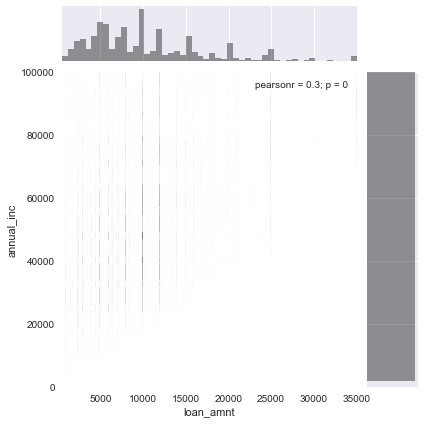

In [244]:
sns.jointplot(x=valid_data['loan_amnt'], y=valid_data['annual_inc'], kind="hex", color="k",ylim=[0,100000])
plt.show()